# 1. Modeling Volatility and VaR

In [1]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
import warnings
warnings.filterwarnings('ignore')


original_df = pd.read_excel(r'../data/barnstable_analysis_data.xlsx', sheet_name=1)
original_df.set_index('date', inplace=True)
original_df.fillna(method='ffill', inplace=True)
original_df['Excess SPY Returns'] = original_df['SPX'] - original_df['TB1M'] 
original_df.head()


,SPX,TB1M,Excess SPY Returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033296,0.002612,-0.035908
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


## 1. Historic VaR

### Plotting VaR over time
We can see that the expanding VaR becomes less and less sensitive to new data as the pool of data points gets larger and larger.

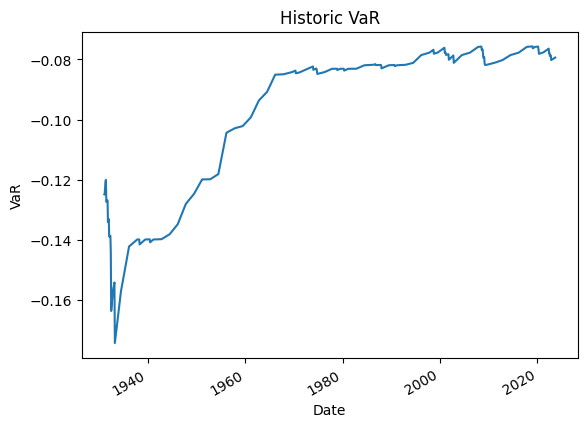

Exceeded Frequency: 35
5% VaR backtest: 3.15%


In [2]:
historic_VaR = original_df['Excess SPY Returns'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()


plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

freq_exceed = sum(original_df['Excess SPY Returns'] < historic_VaR)
exceed = sum(original_df['Excess SPY Returns'] < historic_VaR)/len(historic_VaR.dropna())
print(f'Exceeded Frequency: {freq_exceed}')
print('5% VaR backtest: {:,.2%}'.format(exceed))

We can see that the historic VaR converges to a number as the number of data points increases. This is because the the new data points are unlikely to move the historic VaR by very much if there already exists a lot of data when calculating VaR. We can also see that the historic VaR is not very sensitive to recent data points which may be another draw back. One final observation about historic VaR is that the backtest on the accuracy of VaR may vary from what it actually predicts. We are using a 5% VaR but in reality, we see that only about 3.15% of the historic return exceed this threshold.

## 2. Volatility

### a. Volatility Plots

The Historic window and Expanding window VaR looks like it tends to just converge since new data points hold less and less weight. The Rolling window however, seems to do a better job of reflecting more recent changes in volatility.

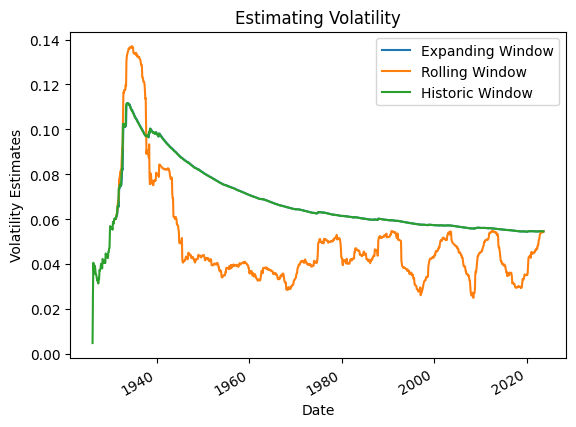

In [3]:
stdev = np.sqrt((original_df['Excess SPY Returns']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))
stdev['Rolling Window'] = np.sqrt((original_df['Excess SPY Returns']**2).shift(1).rolling(60).mean())
stdev['Historic Window'] = np.sqrt((original_df['Excess SPY Returns']**2).shift(0).expanding(0).mean().to_frame('Expanding Window'))
# pd.concat([original_df, stdev], axis=1)
stdev.plot()
plt.title('Estimating Volatility')
plt.ylabel('Volatility Estimates')
plt.xlabel('Date')
plt.show()

### b. VaR 5% 1-month-ahead

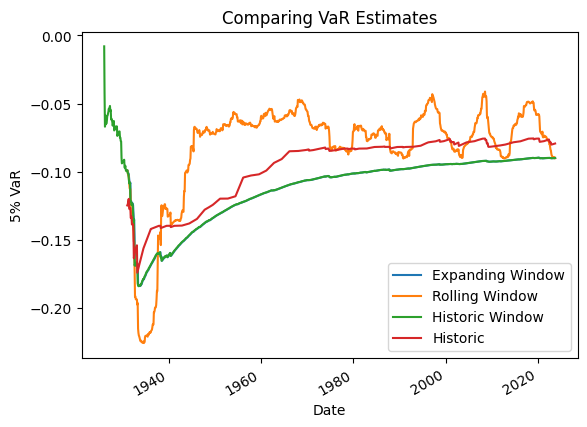

In [4]:
VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

### c. VaR Predictions across Different Windows

In [5]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[original_df.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

,Expanding Window,Rolling Window,Historic Window,Historic
Frequency,1.80%,4.95%,2.05%,3.15%


### d. Comparing VaR Predictions

We can see that Expanding window and Historic window methods for calculating VaR has not been accurate in the back test, while Rolling Window has been relatively accurate. Based on these estimates and their back test performance it seems that Rolling window provides the best estimate for VaR, likely because it uses recent data and can adabt to regime changes relatively quickly.

## 3. CVaR

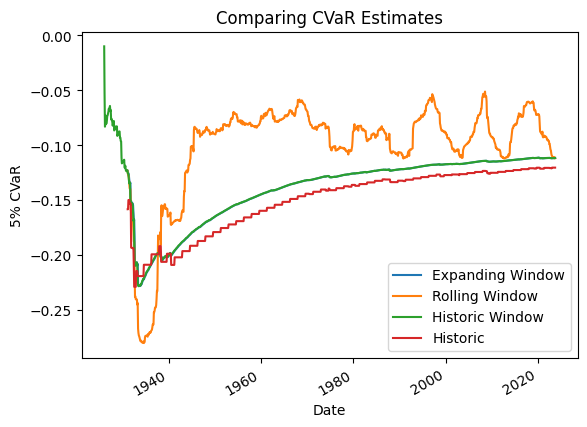

In [6]:
historic_CVaR = []

for i in range(len(original_df)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = original_df[['Excess SPY Returns']][:i-1]
        CVaR = window[window < window.quantile(0.05)]['Excess SPY Returns'].mean()
        historic_CVaR.append(CVaR)

scaling_for_vol = norm.pdf(1.65)/0.05 #trucated normal

CVaR = -scaling_for_vol * stdev

CVaR['Historic'] = historic_CVaR

CVaR.plot()
plt.title('Comparing CVaR Estimates')
plt.ylabel('5% CVaR')
plt.xlabel('Date')
plt.show()

Here we can see that, again, historic window and Expanding window CVaR estimates are converging as the new data points get less and less weight as more and more data points are added to the window, thus the Rolling window technique seems to be better estimate of the current CVaR of future data.

## 4. EWMA and GARCH

In [7]:
GARCH = arch_model(original_df['Excess SPY Returns'], vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 47894645.18374588
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1950.463412480511
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1950.4634158658437
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          0.007870
omega       0.000059
alpha[1]    0.100000
beta[1]     0.879999
Name: params, dtype: float64

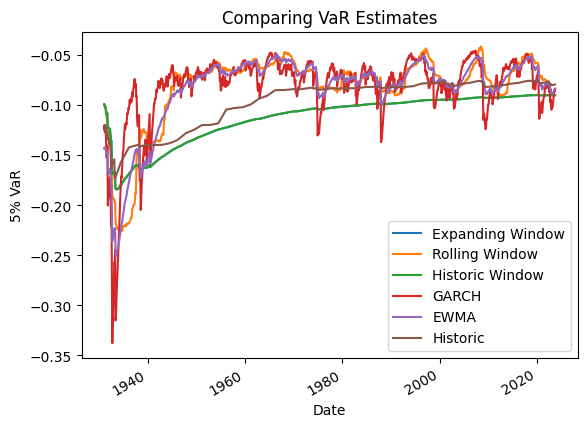

,Expanding Window,Rolling Window,Historic Window,GARCH,EWMA,Historic
Frequency,1.80%,4.95%,1.80%,4.59%,4.32%,3.15%


In [8]:
stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15
theta = 0.97

### Simulate the rest of the period using the initial variance given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta + (1-theta)*(original_df[['Excess SPY Returns']].iloc[i-1,0]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega'] + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(original_df[['Excess SPY Returns']].iloc[i-1,0]**2))
    
stdev.dropna(inplace=True)

VaR = -1.65*stdev
VaR['Historic'] = historic_VaR

VaR.plot()
plt.title('Comparing VaR Estimates')
plt.ylabel('5% VaR')
plt.xlabel('Date')
plt.show()

freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[original_df.loc[VaR.index, 'Excess SPY Returns'] < VaR[col]]) / len(VaR[col].dropna().index)
    
display(freq_df.style.format('{:,.2%}'))

Here we can see that GARCH and EWMA models are both great variations of the rolling window model. Like the rolling window, they more the esimtator (VaR) is predicted using more of the recent data which allows the predictor to be adaptive during trend changes and regime changes.